In [35]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.stats import linregress

# Load transect densities from Soviet NP data

### This code draws on a spreadsheet that's produced from the original .DAT file sent to me by NSIDC

In [36]:
ef = pd.ExcelFile('./transect_densities.xlsx')

sns  = ef.sheet_names

dfs = []

for sn in sns:
    
    df = pd.read_excel('./transect_densities.xlsx',sheet_name=sn)
    
    dfs.append(df)

# Calculate mean density of each transect, and append to list along with day of year the transect was done on

In [37]:
mean_densities = []

measurement_counter = 0

for df in dfs:
    
#     print(df)
    
    for col in df.columns[1:]:
        
        count = np.count_nonzero(np.nan_to_num(df[col]))
        measurement_counter+=count

        mean_densities.append( {'den': np.nanmean(df[col])*1000,
                                'dt':col,
                                    }
                                )
        
print(measurement_counter,len(mean_densities))

4588 580


/tmp/ipykernel_12031/4155445865.py:14: RuntimeWarning: Mean of empty slice
  mean_densities.append( {'den': np.nanmean(df[col])*1000,


# Turn into dataframe and clean

In [38]:
df = pd.DataFrame(mean_densities)

df = df[df['den']>100]
df = df[df['den']<500]

df

,den,dt
0,299.000001,1955-05-31
1,334.000003,1955-06-11
2,368.749999,1955-06-23
3,385.999998,1955-07-04
4,264.999998,1955-11-10
...,...,...
575,328.000003,1991-02-20
576,341.000003,1991-02-28
577,346.000004,1991-03-10
578,348.000005,1991-03-20


# Transform all dates into "days since August 1st"

### Add this as a column to the dataframe

In [39]:
def dt_to_dsa1(dt):
    
    """This function takes in a python datetime.date object
    and returns an integer number of days since the previous August 1st.
    This means that if you input August 1st, the output is 0. The function
    is also sensitive to leapyears, meaning that serving March 1st 2016 
    will give a different value to March 1st 2017 by one day."""
    
    year = dt.year
    month = dt.month
    
    if np.isin(month,[8,9,10,11,12]):
        a1 = datetime.date(year,8,1)
    else:
        a1 = datetime.date(year-1,8,1)
        
    days_since = (dt-a1).days
    
    return days_since

df['dsa'] = [dt_to_dsa1(dt.to_pydatetime().date()) for dt in df['dt']]

# Perform the linear regression on the density data

In [40]:
x = df['dsa']
y = df['den']

lr = linregress(x,y)

lr

LinregressResult(slope=0.3500851327364704, intercept=239.7790004193282, rvalue=0.6169912925038441, pvalue=2.108823420190881e-61, stderr=0.01868679163370836, intercept_stderr=3.514590918988156)

# Produce 'modelled' density values for every real one

### This helps plot the regression line later

In [41]:
def den_from_dsa(dsa):
    
    """This function produces a density value based on
    an integer representing days since August 1st. See
    the dt_to_dsa1 function above for how to produce
    such an integer value. Density value in this function
    is produced by Eqn 2 of the manuscript."""
    
    density = lr[0]*dsa + lr[1]
    
    return density

df['Eq2'] = [den_from_dsa(dsa) for dsa in df['dsa']]

df.sort_values('dsa',inplace=True)

df

,den,dt,dsa,Eq2
448,249.999999,1988-08-20,19,246.430618
331,194.000000,1985-08-21,20,246.780703
449,242.999999,1988-08-30,29,249.931469
65,189.000002,1962-08-31,30,250.281554
353,218.000001,1986-09-07,37,252.732150
...,...,...,...,...
12,315.000005,1957-06-30,333,356.357350
307,374.000001,1983-06-30,333,356.357350
447,371.000004,1988-06-30,334,356.707435
95,378.571429,1965-07-02,335,357.057520


# Calculate RMSE Values

In [45]:
df['error'] = [yi-den_from_dsa(xi) for xi,yi in zip(x,y)]
df['month'] = [dt.month for dt in df['dt']]

rmse_full = np.sqrt(np.nanmean(np.square(df['error'])))

df_cold = df[np.isin(df['month'],[10,11,12,1,2,3,4])]

rmse_cold = np.sqrt(np.nanmean(np.square(df_cold['error'])))

rmse_full, rmse_cold

(34.87650274146571, 34.82219955723007)

# Now produce Mallett et al. 2020 values for each cold-season month

### This is so it can be plotted for comparison. Uses Equation 1 of the manuscript

In [46]:
day_thresh=212

m20_mon = ['Oct','Nov','Dec','Jan','Feb','Mar','Apr']
m20_mon_nums = [10,11,12,1,2,3,4]

mon_densities = {}
for t,mon in zip(range(0,8),m20_mon_nums):
    den = 6.5*t + 274.5
    mon_densities[mon] = den

day_bands = {}
for mon in m20_mon_nums:
    
    first_day = datetime.date(2023,mon,1)
    if mon != 12:
        last_day = datetime.date(2023,mon+1,1)-datetime.timedelta(days=1)
    else:
        last_day = datetime.date(2023,1,1)

    day_bands[mon] = (dt_to_dsa1(first_day),dt_to_dsa1(last_day))

# Produce month-based x-ticks and labels for the figure

### These only hold for non-leap-year case

In [47]:
sup_th = '$^{\mathrm{st}}$'
month_start_dsa = [0]
counter = 0
month_names = ['Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun','Jul']

month_names = [mn+ f' 1{sup_th}' for mn in month_names]
for d in [31,31,31,30,31,28,31,30,31,30,31,]:
    counter +=d
    month_start_dsa.append(counter)

# Produce the figure

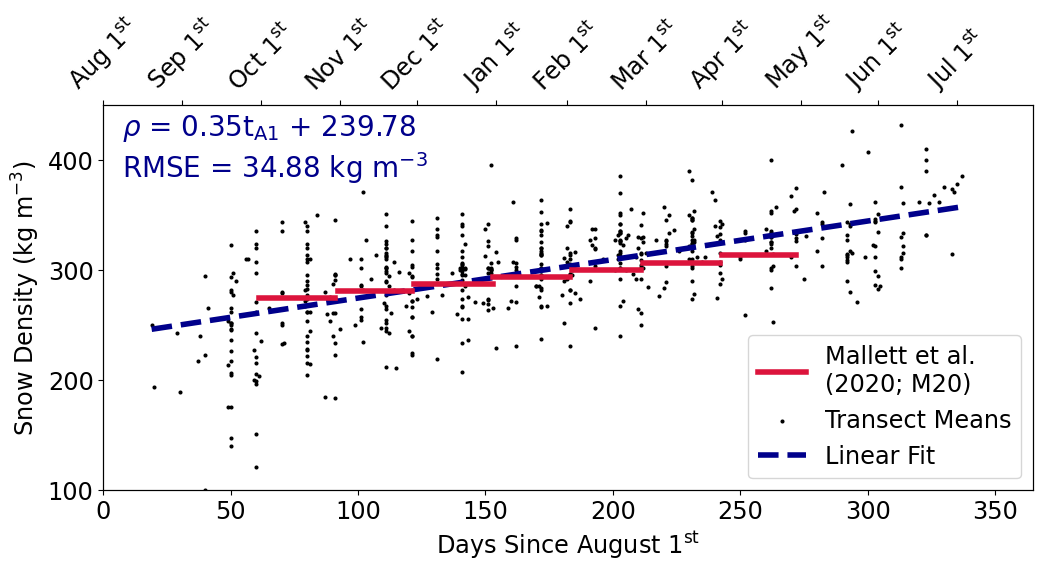

In [58]:
fig, ax = plt.subplots(1,1,figsize=(12,5))

### Define your colour scheme ###

c1='crimson'
c2='darkblue'
c3='k'

### Plot M20 ###

for key in day_bands.keys():
    ax.plot(np.array([day_bands[key][0],day_bands[key][1]]),
             [mon_densities[key],mon_densities[key]],
            color=c1,lw=4,zorder=10)
    
ax.plot([],
         [],
         label='Mallett et al.\n(2020; M20)',
        color=c1,lw=4,zorder=10)

### Plot Scatter ###

ax.scatter(df['dsa'],
            df['den'],
            marker='.',
            s=15,
            color=c3,
            label='Transect Means')

### Plot Equation 1 Regression Line ###

ax.plot(df['dsa'],df['Eq2'],
        color=c2,
        label='Linear Fit',
       lw=4,ls='--')


### Handle X-Axis Ticks ###

ax.set_xlabel(f'Days Since August 1{sup_th}',fontsize='xx-large')

ax.set_xticks(np.arange(0,351,50))
ax.set_xticklabels(labels=np.arange(0,351,50),
                   rotation=0,fontsize='xx-large')

axb = ax.twiny()
axb.set_xticks(month_start_dsa)
axb.set_xticklabels(month_names,fontsize='xx-large',rotation=45)
axb.set_xlim(0,365)

### Y-Axis Ticks and Label ###

ax.set_yticks(np.arange(100,501,100))
ax.set_yticklabels(np.arange(100,501,100),fontsize='xx-large')
ax.set_ylabel('Snow Density (kg m$^{-3}$)',fontsize='xx-large')

ax.legend(loc='lower right',fontsize='xx-large')

### Annotation ###

r_val = str(np.round(lr[2],decimals=2))
rmse_str = np.round(rmse_full,decimals=2)
kg3 = 'kg m$^{-3}$'
r_str = f'\nRMSE = {rmse_str} {kg3}'
sub_d = '$_\mathrm{A1}$'
ax.annotate(fr'$\rho$ = {np.round(lr[0],decimals=3)}t{sub_d} + {np.round(lr[1],decimals=2)}'+r_str,
             xy=(0.02,0.98),xycoords='axes fraction',
             fontsize=20,color=c2,va='top')



ax.set_xlim(0,365)
ax.set_ylim(100,450)

odir = '/home/robbie/Dropbox/Apps/Overleaf/Densification/figs/'

plt.savefig(f'{odir}fig1.jpg',bbox_inches='tight',dpi=400)

plt.show()

# Make leap year calculation for reviewer responses

In [30]:
### 2020 was a leap year but 2021 was not

datetime.date(2021,3,1).timetuple().tm_yday, datetime.date(2020,3,1).timetuple().tm_yday

(60, 61)